# Import Libraries

---






In [2]:
#Magic and Console Commands
%load_ext tensorboard
!pip install keras-metrics

#System Libraries
import os
import datetime 
import sys 
from pathlib import Path

#Standard Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Image Specific Libraries
import cv2
import PIL
from PIL import Image
from PIL import ImageFilter
from scipy import ndimage

#Tensorflow and Keras Libraries
import tensorflow as tf
import keras
from keras import metrics
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras_metrics import binary_average_recall, binary_f1_score, binary_false_negative, binary_false_positive, binary_precision, binary_recall, binary_true_negative, binary_true_positive
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications import vgg16



#Scikit Lean Libraries
from sklearn.model_selection import train_test_split

#Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')
os.mkdir('/content/train')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ModuleNotFoundError: No module named 'google.colab'

# Instantiate Global Functions

---

In [ ]:
#Functions

def image_viewer(image_index):
  img_view = PIL.Image.open(image_index)
  return img_view

#-----------------------------------------------------------

def predictImage(filename,model):
    img = image.load_img(filename, target_size=(224, 224))
    plt.imshow(img)
    
    img_array = image.img_to_array(img)
   
    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_batch/255.

    prediction = model.predict(img_preprocessed)

    prediction = np.max(prediction, axis=1).round()

    print(prediction)
    if prediction >= .51:
        
        plt.xlabel("adult",fontsize=30)
        
    
    else:
        
        plt.xlabel("child",fontsize=30)

#--------------------------------------------------------------------

def reset_model(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model): #if you're using a model as a layer
            reset_weights(layer) #apply function recursively
            continue

        #where are the initializers?
        if hasattr(layer, 'cell'):
            init_container = layer.cell
        else:
            init_container = layer

        for key, initializer in init_container.__dict__.items():
            if "initializer" not in key: #is this item an initializer?
                  continue #if no, skip it

            # find the corresponding variable, like the kernel or the bias
            if key == 'recurrent_initializer': #special case check
                var = getattr(init_container, 'recurrent_kernel')
            else:
                var = getattr(init_container, key.replace("_initializer", ""))

            if var is not None:
                var.assign(initializer(var.shape, var.dtype))

#--------------------------------------------------------------------

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    

# Import Datasets and Data Cleaning

---

In [ ]:
#Unzip Image Datasets
!unzip '/content/drive/MyDrive/project_5_group_3/data/UTKFace.zip'

In [ ]:
#Creating Datasets and Cleaning
path = '/content/UTKFace'
temp_path = Path(path)
faces = list(temp_path.glob('*.jpg'))

#----------------------------------------------

df = pd.DataFrame(columns = ['images','age'])

for img in faces: 
  new_img = str(img)
  img = new_img.split("/")

  img_name = img[3]
  img = img_name.split("_")

  img[0] = int(img[0])
  if img[0] > 18:
    img[0] = '1'
  else: img[0] = '0'

  df2 = {'images': new_img, 'age': img[0]}
  df = df.append(df2, ignore_index = True)

df.head()

#----------------------------------------------

,images,age
0,/content/UTKFace/35_1_2_20170116164633129.jpg....,1
1,/content/UTKFace/59_0_0_20170109012750162.jpg....,1
2,/content/UTKFace/25_1_4_20170117195158652.jpg....,1
3,/content/UTKFace/61_0_3_20170119211813409.jpg....,1
4,/content/UTKFace/34_0_1_20170113142138427.jpg....,1


# Feature Engineering and Train Test Splits

---

In [ ]:
#Initial Train Test Split
X = df['images']
y = df['age']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=808, stratify=y)

d_train = pd.DataFrame({
    'images':X_train,
     'age': y_train})

#---------------------------------------------------------
#Second Train Test Split for Validation Data
x_data = d_train['images']
y_data = d_train['age']
X_tr, X_val, y_tr, y_val = train_test_split(x_data, y_data, random_state=808, stratify=y_data)

#---------------------------------------------------------
#Creating Train Dataset
train= pd.DataFrame({
    'images':X_train,
     'age': y_train})

#Creating Validation Dataset
val = pd.DataFrame({
    'images':X_val,
     'age': y_val})

#Creating Test Dataset
test = pd.DataFrame({
    'images':X_test,
     'age': y_test})

#---------------------------------------------------------

print(f'Train set {train.shape}')
print(f'Val set {val.shape}')
print(f'Test set {test.shape}')

Train set (17781, 2)
Val set (4446, 2)
Test set (5927, 2)


In [ ]:
#Augmenting Images to Address Imbalanced Classes
# ---------------------------------------------------------
os.mkdir('/content/train6')
filelist = train['images'].loc[(train['age']=='0')].tolist()
for imagefile in filelist:
    img_n = imagefile.split("/")[3]
    img_num = img_n.split(".")[0]
    os.chdir('/content/UTKFace/')
    img_name = imagefile.split('/')[3]
    im=Image.open(imagefile)
    im=im.convert("RGB")
    im_unsharp=im.filter(ImageFilter.UnsharpMask)
    img_fliplr = np.fliplr(im)
    rotate_2 = Image.fromarray(ndimage.rotate(img_fliplr, -40, reshape=False))
    rotate_3 = Image.fromarray(ndimage.rotate(im, -40, reshape=False))
    rotate_4 = Image.fromarray(ndimage.rotate(img_fliplr, 40, reshape=False))
    os.chdir('/content/train6')
    im_unsharp.save(img_num+"5.jpg")
    rotate_2.save(img_num+"7.jpg")
    rotate_3.save(img_num+"8.jpg")
    rotate_4.save(img_num+"9.jpg")

#---------------------------------------------------------

path_aug = '/content/train6'
temp_path_aug = Path(path_aug)
faces_aug = list(temp_path_aug.glob('*.jpg'))

for img in faces_aug:
  new_img = str(img)
  img = new_img.split("/")

  img_name = img[3]
  img = img_name.split("_")

  img[0] = int(img[0])
  if img[0] > 18:
    img[0] = '1'
  else: img[0] = '0'

  df3 = {'images': new_img, 'age': img[0]}
  train = train.append(df3, ignore_index = True)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

print(train.shape)
print(train['age'].value_counts(normalize=True))

(31265, 2)
0    0.539101
1    0.460899
Name: age, dtype: float64


In [ ]:
os.chdir('./')

In [ ]:
#Universal Values
batch = 32
img_height = 224
img_width = 224

#---------------------------------------------------------
#Creating Our Image Data Generators
train_gen= ImageDataGenerator(rescale=1/255)
test_gen= ImageDataGenerator(rescale=1/255)

train_data = train_gen.flow_from_dataframe(
    # color_mode = 'grayscale',
    dataframe = train,
    x_col = 'images',
    y_col = 'age',
    seed = 808,
    batch_size = batch,
    shuffle = True,
    class_mode = 'binary',
    target_size = (img_height, img_width)
)

test_data = test_gen.flow_from_dataframe(
    dataframe = test,
    x_col = 'images',
    y_col = 'age',
    seed = 808,
    batch_size = 1,
    shuffle = False,
    class_mode = None,
    target_size = (img_height, img_width)
)

val_data = train_gen.flow_from_dataframe(
    # color_mode = 'grayscale',
    dataframe = val,
    x_col = 'images',
    y_col = 'age',
    seed = 808,
    batch_size = 1,
    shuffle = True,
    class_mode = 'binary',
    target_size = (img_height, img_width)
)

Found 31265 validated image filenames belonging to 2 classes.
Found 5927 validated image filenames.
Found 4446 validated image filenames belonging to 2 classes.


# Convolutional Neural Network

---

In [ ]:
!rm -rf ./logs/

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto', restore_best_weights=True)

log_dir = "/content/drive/MyDrive/project_5_group_3/data/Models/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)

model = Sequential()

#1st Convolutional Layer
model.add(layers.Conv2D(32, (5,5), activation = 'relu', padding = 'same', input_shape = (img_height, img_width, 3)))
model.add(BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

#2nd Convolutional Layer
model.add(layers.Conv2D(64, (5,5), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(layers.Dropout(.2))

#3rd Convolutional Layer
model.add(layers.Conv2D(128, (5,5), activation = 'relu', padding = 'same', kernel_regularizer = 'l2'))
model.add(BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(layers.Dropout(.2))

#4th Convolutional Layer
model.add(layers.Conv2D(256, (5,5), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

#5th Convolutional Layer
model.add(layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

#6th Convolutional Layer
model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(layers.ZeroPadding2D(padding=(1, 1)))
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(layers.GlobalAveragePooling2D())

#Flattening
model.add(layers.Flatten())

#Fully Connected Layer
model.add(layers.Dense(512, activation = 'relu'))
model.add(BatchNormalization())

model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = opt, 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', 
                         metrics.Precision(), metrics.Recall(), 
                         metrics.AUC(),
                         metrics.FalseNegatives(), metrics.FalsePositives(),
                         metrics.TrueNegatives(),
                         metrics.TruePositives()])

In [ ]:
model.summary()

In [ ]:
results = model.fit(train_data,
                    validation_data=val_data, 
                    epochs=100,
                    callbacks=[tensorboard_callback, early_stop],
                    batch_size=32)

Epoch 1/100
978/978 [==============================] - 90s 89ms/step - loss: 0.5658 - accuracy: 0.8578 - precision_3: 0.8204 - recall_3: 0.8810 - auc_3: 0.9272 - false_negatives_1: 738.4321 - false_positives_1: 1221.1645 - true_negatives_1: 7204.9193 - true_positives_1: 6502.9755 - val_loss: 0.5565 - val_accuracy: 0.8201 - val_precision_3: 0.8187 - val_recall_3: 0.9992 - val_auc_3: 0.8129 - val_false_negatives_1: 3.0000 - val_false_positives_1: 797.0000 - val_true_negatives_1: 46.0000 - val_true_positives_1: 3600.0000
Epoch 2/100
978/978 [==============================] - 83s 85ms/step - loss: 0.2185 - accuracy: 0.9263 - precision_3: 0.8973 - recall_3: 0.9478 - auc_3: 0.9730 - false_negatives_1: 375.3534 - false_positives_1: 792.2584 - true_negatives_1: 7687.4923 - true_positives_1: 6824.7365 - val_loss: 0.2690 - val_accuracy: 0.9089 - val_precision_3: 0.9210 - val_recall_3: 0.9709 - val_auc_3: 0.9226 - val_false_negatives_1: 105.0000 - val_false_positives_1: 300.0000 - val_true_negati

In [ ]:
# model.save('/content/drive/MyDrive/project_5_group_3/data/Models/cnn')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/project_5_group_3/data/Models/cnn/assets


# CNN Evaluation


---



In [ ]:
model.evaluate(train_data, verbose=1)

978/978 [==============================] - 49s 50ms/step - loss: 0.0315 - accuracy: 0.9945 - precision_3: 0.9914 - recall_3: 0.9967 - auc_3: 0.9999 - false_negatives_1: 47.0000 - false_positives_1: 125.0000 - true_negatives_1: 16730.0000 - true_positives_1: 14363.0000


[0.031532756984233856,
 0.9944986701011658,
 0.9913721680641174,
 0.9967383742332458,
 0.9998643398284912,
 47.0,
 125.0,
 16730.0,
 14363.0]

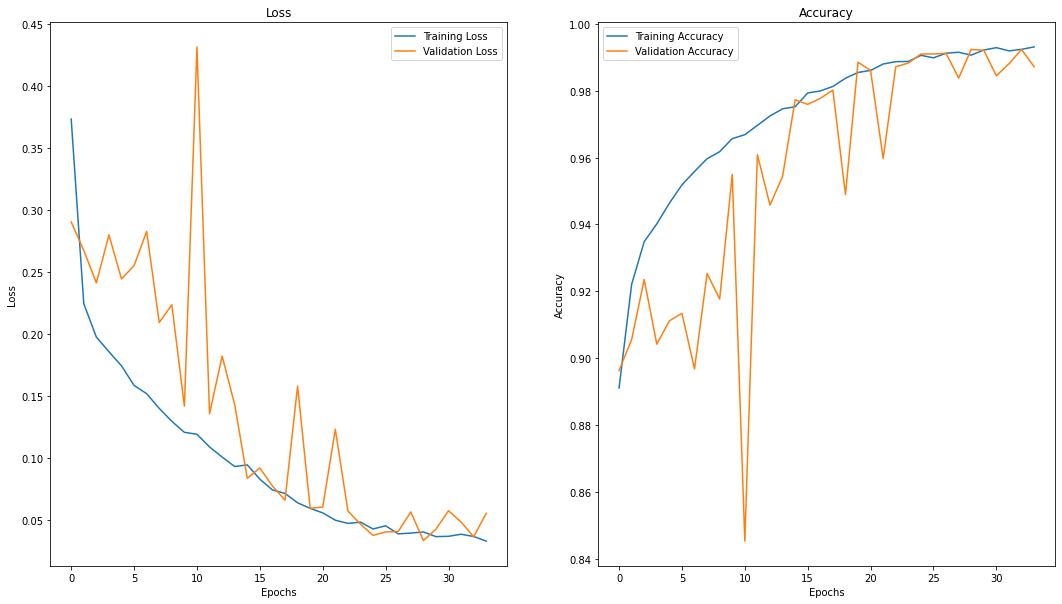

In [ ]:
f, axs = plt.subplots(1,2,figsize=(18,10))
axs[0].plot(results.history['loss'],label = 'Training Loss')
axs[0].plot(results.history['val_loss'], label = 'Validation Loss')
axs[1].plot(results.history['accuracy'], label = 'Training Accuracy')
axs[1].plot(results.history['val_accuracy'], label = 'Validation Accuracy')
axs[0].set(xlabel='Epochs',ylabel='Loss', title='Loss')
axs[1].set(xlabel = 'Epochs', ylabel='Accuracy', title = 'Accuracy')
axs[1].legend(labels = ['Training Accuracy', 'Validation Accuracy'])
axs[0].legend(labels = ['Training Loss', 'Validation Loss'])
plt.show();

In [ ]:
# %tensorboard --logdir logs/fit

In [ ]:
STEP_SIZE_TEST=test_data.n//test_data.batch_size
test_data.reset()
pred=model.predict_generator(test_data,
steps=STEP_SIZE_TEST,
verbose=1)

filenames=test_data.filenames
predict_df=pd.DataFrame({"Filename":filenames,
                      "Predictions":np.max(pred, axis=1).round()})
predict_df.to_csv("results.csv",index=False)

predict_df

In [ ]:
predictImage(predict_df['Filename'][384],model)

# ResNet50 Transfer Learning
### We will attempt to Increase our models performance by leveraging the ResNet50 model. We will first freeze the convolutional blocks so that we can use it as just an image feature extractor.
----

In [ ]:
# resmodel = ResNet50(weights='imagenet')

In [ ]:
# res = ResNet50(include_top=False, weights='imagenet', 
#                                      input_shape=(img_height, img_width, 3))

# output = res.layers[-1].output
# output = keras.layers.Flatten()(output)
# res_model = Model(res.input, output)

# res_model.trainable = False
# for layer in res_model.layers:
#     layer.trainable = False
    
# import pandas as pd
# pd.set_option('max_colwidth', None)
# layers = [(layer, layer.name, layer.trainable) for layer in res_model.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [ ]:
# from tensorflow.keras import layers
# opt = Adam(lr=0.001)
# model = Sequential()
# model.add(res)
# model.add(layers.Flatten())
# model.add(layers.Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy'])

In [ ]:
# res_results = model.fit(train_data,
#                     validation_data=val_data, 
#                     epochs=100,
#                     callbacks=[tensorboard_callback, early_stop],
#                     batch_size=32)

In [ ]:
# model.evaluate(test_data, verbose=1)

In [ ]:
# model.save('/content/drive/MyDrive/project_5_group_3/data/Models/resnet_model')

# VGG - 16 Feature Extraction

### We will attempt to Increase our models performance by leveraging the VGG-16 model. We will first freeze the convolutional blocks so that we can use it as just an image feature extractor.
---



In [ ]:
# vgg = keras.models.load_model('/content/vgg_model.tf')

In [ ]:
# vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
#                                      input_shape=(img_height, img_width, 3))

# output = vgg.layers[-1].output
# output = keras.layers.Flatten()(output)
# vgg_model = Model(vgg.input, output)

# vgg_model.trainable = False
# for layer in vgg_model.layers:
#     layer.trainable = False
    
# import pandas as pd
# pd.set_option('max_colwidth', None)
# layer = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
# pd.DataFrame(layer, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [ ]:
# train_features_vgg = get_bottleneck_features(vgg_model, train_data)
# validation_features_vgg = get_bottleneck_features(vgg_model, val_data)

# print('Train Bottleneck Features:', train_features_vgg.shape, 
#       '\tValidation Bottleneck Features:', validation_features_vgg.shape)

In [ ]:
# from tensorflow.keras import layers
# input_shape = vgg_model.output_shape[1]

# from tensorflow.keras import layers
# opt = Adam(lr=0.0001)

# vgg = Sequential()
# vgg.add(keras.layers.InputLayer(input_shape=(input_shape,)))
# model.add(BatchNormalization())
# vgg.add(layers.Flatten())
# model.add(BatchNormalization())
# vgg.add(layers.Dense(1, activation='sigmoid'))

# vgg.compile(loss='binary_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy'])

In [ ]:
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# vgg_results = vgg.fit(x=train_features_vgg, y=np.asarray(train_data.classes),
#                     validation_data=(validation_features_vgg, np.asarray(val_data.classes)),
#                     batch_size=32,
#                     epochs=100,
#                     verbose=1,
#                     callbacks = [tensorboard_callback, early_stop])

In [ ]:
# vgg.save('/content/drive/MyDrive/project_5_group_3/data/Models/vgg_model')